![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Shakespeare with a Character-Level RNN

[In the RNN classification tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify text one character at a time. This time we'll generate text one character at a time.

```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

This one might make you question the series title &mdash; "is that really practical?" However, these sorts of generative models form the basis of machine translation, image captioning, question answering and more. See the [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) for more on that topic.

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) builds on this model to add a category as input

# setup

In [1]:
!pwd

/content


In [0]:
from pathlib import Path
dataset_path = Path.home() / 'data/rnn_generator'; dataset_path
tmp_path = dataset_path / 'tmp/'
!mkdir -p $tmp_path

In [2]:
!ls -lah /content/data/rnn_generator

total 1.1M
drwxr-xr-x 3 root root 4.0K Apr 24 12:39 .
drwxr-xr-x 3 root root 4.0K Apr 24 09:58 ..
-rw-r--r-- 1 root root 709K Apr 24 10:14 mickiewicz.txt
-rw-r--r-- 1 root root 219K Apr 23 17:58 pan_tadeusz.txt
drwxr-xr-x 3 root root 4.0K Apr 24 12:35 tmp
-rw-r--r-- 1 root root 142K Apr 24 10:05 witkacy_szewcy.txt


# vm monitoring

In [0]:
import os
import psutil

def print_memsize():
  process = psutil.Process(os.getpid())
  print(f'{process.memory_info().rss / 1024**3:.5} GB')

In [3]:
print_memsize()

0.12249 GB


# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [0]:
# fn = 'data/tiny-shakespeare.txt'
# fn = dataset_path / 'mickiewicz.txt'
# fn = dataset_path / 'witkacy_szewcy.txt'
fn = dataset_path / 'pan_tadeusz.txt'

In [3]:
# import unidecode
import string
import random
import re

# file = unidecode.unidecode(open(fn).read())
file = open(fn).read()
file_len = len(file)
print('file_len =', file_len)

# ascii only
# all_characters = string.printable
# n_characters = len(all_characters)


# all chars found in file
all_characters = sorted(list(set(file))); print(all_characters[:10])
n_characters = len(all_characters); print(n_characters)

file_len = 203037
['\n', ' ', '!', '"', '%', "'", '(', ')', ',', '-']
89


To make inputs out of this big string of data, we will be splitting it into chunks.

In [7]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

się wparło,
Ale za każdym razem trzech nogi zadarło,
Wiec uciekli pod lamus; a już był poranek.
Pan Stolnik wesoł wyszedł ze strzelbą na ganek,
I skoro s pod lamusa moskal łeb wychylił,
On dawał zaraz ognia a nigdy nie mylił,
Za każdym razem czarny kaszkiet w trawę padał,
I już się rzadko który z za ściany wykradał.
Stolnik widząc strwożone swe nieprzyjaciele,
Myślił zrobić wycieczkę, porwał karabe


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [9]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('ala ma kota'))

Variable containing:
 41
 52
 41
  1
 53
 41
  1
 51
 55
 59
 41
[torch.LongTensor of size 11]



Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [0]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [0]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [14]:
n_epochs = 2000 # 3000
print_every = 100
plot_every = 1
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
print(decoder, flush=True)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

from tqdm import tqdm

for epoch in tqdm(range(1, n_epochs + 1)):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        e = evaluate('Wh', 200)
        print('\n[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(e, '\n', flush=True)

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

RNN(
  (encoder): Embedding(89, 100)
  (gru): GRU(100, 100)
  (decoder): Linear(in_features=100, out_features=89)
)


  5%|▍         | 99/2000 [00:44<14:08,  2.24it/s]


 44s (100 5%) 2.3588]
Whąc pole go_ie wiszarzy ieśonie, Panie zasię,
Bowie takowinu towojyci kurzekniwa koć przesty,
Zsię wrzysta tenta mierząci się polęczyi piłero złorzłowyści wkiera zakrzyj,
Kicu nassię szywa pikrzył sczn 



 10%|▉         | 199/2000 [01:28<13:22,  2.24it/s]


 29s (200 10%) 2.2161]
Whać  lak kraz wyskowanąd że starach i wiak sto sialicy grzaka -- niewty i śłodził ko posię przyna mnierzy na zierszem stawieć prokaci,
Zale to do jakę głozczecz
-- Wizredzi i w mieli prystały, padówrac 



 15%|█▍        | 299/2000 [02:13<12:37,  2.24it/s]


 13s (300 15%) 2.3984]
Whużem
Natrzycy przydowońchmo stać s kim zamieniej dokon pięko obo kierobie,
W pradrzy strzykła dłożyniecy kowa stał spubiały,
Na krzych obryłoniemiem, krzykły storce do stranie,
Jako krzychwą strzy dła 



 20%|█▉        | 399/2000 [02:58<11:54,  2.24it/s]


 58s (400 20%) 2.0652]
Whęcie młyści w niesktów Horwany barkalnem lapiewiem romienia,
Prywa stem o głąkł dojania do w rzena wilieka czan płował do okrywaział zdo dona odziesta pociego Pam ręko Dzukał, po ramiem mnie do podeus 



 25%|██▍       | 499/2000 [03:42<11:10,  2.24it/s]


 43s (500 25%) 2.1573]
Whuch bogła;
W buczniem poszech séj z gdy prziebia,
Mowiem, z czykome.

    Tążał siądzieje, asz nim odkoście głowa mimnie głojego jak dom sądzich nam goła, powalków,
Zwosta zawiedzie dzieru Teludnie w  



 30%|██▉       | 599/2000 [04:27<10:25,  2.24it/s]


 27s (600 30%) 2.0797]
Whał szele, wojskomerzem.
Niecz praskał i wrócił,
I podział szeredzi nim czaszem oczuchany,
Moczy ku więdzonu po prawnie
-- Do jenach, w towanici,
Ale charz zawiedy obie zwiele się kiesta! czył w luczyl 



 35%|███▍      | 699/2000 [05:12<09:40,  2.24it/s]


 12s (700 35%) 2.1647]
Whusze o obrodzić szęściu, śćmię waczelu stołał choć ręko i odni a prawnie i bławał
Powszaski Hradził, bięła i pielski kolić.
Telucharnie murecz po grubie.



Hrabiał; na wiemy star oka chwili pożewało  



 40%|███▉      | 799/2000 [05:57<08:56,  2.24it/s]


 57s (800 40%) 2.0398]
Whałt domosłem nięc zastem się więc, wykrznał;
Od skrzecz na zawznie zelu, szczed poteli w do między dary,
Śliwił szkałtą, znala Pan okora:
Czerwszy dobarzczy.
O tak s cepras grałki,
I do myśnie, z zeru 



 45%|████▍     | 899/2000 [06:41<08:12,  2.24it/s]


 42s (900 45%) 2.3444]
Whyją w prawéj usie bardzo podźwieli wich, obaci,
I w laszczany.

«Graszem przezwi szlach odartował; boże Hrabia s przyprzy na młodzie;
Na na pobał, rozbNował paniozelyów,
W w ramiają grzechynieru;
Brzy 



 50%|████▉     | 999/2000 [07:26<07:27,  2.24it/s]


 27s (1000 50%) 1.8919]
Whijolach się darjał i uczko do trawnie,
Ob w wiałem zabita
Niebuplkość, o postaniał,
Przebia stołą jadatniej kamek werzysteli, obrzachała na niebucionéj siebia przytali odwierz mi strzeli znadając, jes 



 55%|█████▍    | 1099/2000 [08:11<06:43,  2.24it/s]


 12s (1100 55%) 2.0479]
Whydziu  glik, Ceserze!
Widać to krenienie, stronie siał pan kolił po podsieżne to in w nie wrócca w ostawana wiedzie? że żylą,
Krzywa przy popanie niewszystwej wilcze wyprosory Pan mienie sychodzi rozo 



 60%|█████▉    | 1199/2000 [08:56<05:58,  2.24it/s]


 56s (1200 60%) 2.0531]
Whéj na potakł;
Rowie je z pięczystać s który i piedos miał ssobać zwierz mówne i od przestój cały
Tak za jedŻe od ostaczeń nie wychcie zmienie;
Rzekty mój mu za polał
Wodat młodzie Berajęłem,
A trzeczt 



 65%|██████▍   | 1299/2000 [09:40<05:13,  2.24it/s]


 41s (1300 65%) 2.0607]
Whiępsów,
Z napernie, szczena i konajdzie do lotystwo, wypata,
Chwodna lewa dwierze niém okował do choć kłótków, strzaskośnia, nie lisami wielkie.
Podkomy mając się fanownka,
Ili w lasias zawsze i dworz 



 70%|██████▉   | 1399/2000 [10:25<04:28,  2.24it/s]


 25s (1400 70%) 1.9414]
Whąstów kota;
Tenę widoczę
Zwierzegów się, też Hraba się się naledziem strzeli róstwy zioda.

Wzrosta się się paniało ciestrzu Sanono siwy
Światę się swoła; się wiógów też w przedewł, strasła.

Niemim R 



 75%|███████▍  | 1499/2000 [11:09<03:43,  2.24it/s]


 10s (1500 75%) 1.9627]
Whistęcie bielki grzyknął;
Pakował Pan się jak posta?
W nie końce i klewał były,
Stolczyny od w wiém wszyska pladzilnym
Na do jéj były sam patrzego siędze,
Wypisie zadrzegle mówi w pomnie nagdyle że mu  



 80%|███████▉  | 1599/2000 [11:54<02:59,  2.24it/s]


 55s (1600 80%) 1.9424]
Whcie! stoły był w cełos zwiacie ustary obora,
W u na był wrażo strwaszaję.
Już maję o cilkowąc się zarwora,
I szarcym się ukraztwie gorzetewga grania Robak zebyło zachać jak zamku był był która skili,
 



 85%|████████▍ | 1699/2000 [12:39<02:14,  2.24it/s]


 39s (1700 85%) 2.1208]
Whzieczył podanie
Po wierz Tadeusz i sercia daléj piewszy niemych,
Niemowny szeroka, palejemi uczął, wzerwie i tylko,
Co się w szeracy się więcz i pawciu niechowią,
Między padku poiedź sobie,
Ją radnie  



 90%|████████▉ | 1799/2000 [13:24<01:29,  2.24it/s]


 24s (1800 90%) 1.8191]
Whojdzie,
Chciała cuta dworzy podnosuje mi kontość przedziewie, przecie: dworzy.

Ale dzie. Jaga polero zamkoma wyrote,
Co goście i głową oczy,
Zszym potém który, rodzami pojętwa,
Zaszyst do doboła w gr 



 95%|█████████▍| 1899/2000 [14:09<00:45,  2.24it/s]


 9s (1900 95%) 1.9731]
Whojen; i wystrzelby odzawek
Go którą roskusząc w Litwiony, jedne dumania,
Kudził posta w ku lubi drzewa;
Tyła parodziła do zab i już sporemu
Cię rzekł dało biętał
A sątwe jako kikto wyglądza, s była si 



100%|█████████▉| 1999/2000 [14:53<00:00,  2.24it/s]


 54s (2000 100%) 1.9794]
Whętką zdanie.
Polno wielby sposoby sam jedne brzecie westajszy.
Powieli strzelcy w pole jak Leciek to czasku mieszkanie co szycy do się Sprzód trz obek się obremarz Pan Stałta srewnąt psercić doblowéj  



100%|██████████| 2000/2000 [14:54<00:00,  2.24it/s]


# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

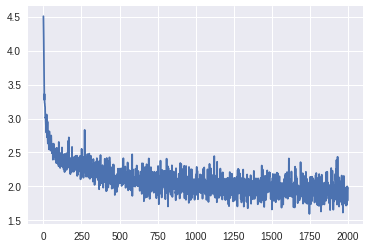

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [24]:
print(evaluate('Th', 200, temperature=0.8))

Thał, a połuszki?
Mały jej w drożąga z nalik z kończył popieczny okryż brapa,
Był się w naszej się się strugi się bietczę--
       je z moje wiecze pomory,
Oszajego kramiele bo widzieraz wpada mobieje s


Lower temperatures are less varied, choosing only the more probable outputs:

In [26]:
print(evaluate('Th', 200, temperature=0.2))

Tho mieszczył się podrował się się się się się wielki się nieszara,
Wierze się się pod przyjacień się wierczy,
A wiecznie się podrował, 
Wiedził się zapał się się się wierzy podrował,
Zabaczył się do do


Higher temperatures more varied, choosing less probable outputs:

In [25]:
print(evaluate('Th', 200, temperature=1.4))

ThÓ)

tańserych waląscie! Has romu leży.
Wojrźna? Lźitaty
szłysenne, kryjy rutu,
Od rycionabyfrapy; - posru;
Ni mrzewli, szmurek rzuży:
"Szrozabamiąli: WIFTą. SŁEMIÓN PISTNOść jakiasry, rąm3-słyśny, 
  


# Exercises

* Train with your own dataset, e.g.
    * Text from another author
    * Blog posts
    * Code
* Increase number of layers and network size to get better results

**Next**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)

# Save model

In [0]:
ALLCHARS, MODEL = ['all_characters', 'model']

fn_pan_tadeusz = {ALLCHARS: 'all_characters.pan_tadeusz.p', MODEL: 'pan_tadeusz.h100.l1.e2000.cpu.torch'}

fn_dict = fn_pan_tadeusz

In [0]:
# save all_characters
import pickle

pickle.dump(all_characters, open(tmp_path / fn_dict[ALLCHARS], 'wb'))

In [0]:
# all_characters = pickle.load( open( tmp_path / fn_dict[ALLCHARS], 'rb' ) )
# n_characters = len(all_characters)

In [20]:
decoder.state_dict

<bound method Module.state_dict of RNN(
  (encoder): Embedding(89, 100)
  (gru): GRU(100, 100)
  (decoder): Linear(in_features=100, out_features=89)
)>

In [21]:
# save model
model_path = tmp_path / fn_dict[MODEL]
torch.save(decoder, model_path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# decoder = torch.load(model_path)